In [1]:
# import sys
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install nltk
# !{sys.executable} -m pip install -U spacy
# !{sys.executable} -m pip install gensim
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m pip install pyLDAvis
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install yellowbrick
# !{sys.executable} -m pip install langdetect
# !{sys.executable} -m pip install dill

# !{sys.executable} -m pip install wordcloud

In [87]:
# Run in python console
import re
import os
import numpy as np
import pandas as pd
import random
import dill

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk; nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pickle

from yellowbrick.features import FeatureImportances
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.model_selection import CVScores

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Understanding how listing description influence price and listing rating

The AirBnb dataset provides with features not only that have numeric or structured values but also unstructured data. To mention a few examples: the name of of the property, a short description of the space, an overview of the neighborhood and a description of the listing itself. As part of our project we would like to use Natural Language Processing techniques to understand how unstructured data available for each listing might influence price.

The reason we believe that there might be a relationship betweeen the listing description and the price is because 
we think that what makes a listing valuable is not only their features per se but also the way the place is presented to the potential guest. This, not only includes the pictures of the listing but also the words that the listing owners pick to describe their listing and assumingly seeks to attrack their potential customers. We assume that by including certain words in the description could potentially increase the attractiveness of a certain property to be rented. Thus, due to supply and demand law, can assume that the more demanded a property is, the higher the value it could have. 

To begin with the analysis we want to see if there are similarities in the way listing owners describe their place and the price they charge per night. We proceed with the assumption that listings with similar features will use similar words to describe their property. Furthermore we are curious about how words in the description could inform us about the listing's overall rating.

For this reason we will be using this notebook to try to answer the following questions:

1. Do listings using similar words in their description share a similar price?
2. Do listings using similar words in their description share other features that are relevant to predict price?
3. Do listings using similar words in their description end up having similar guest acceptance/rating?

For this purpose we will first, use Latent Dirichlet Allocation to elicit the latent topics in the description. Latent Dirichlet Allocation is an unsupervised algorithm, largely used in Natural Language Processing to perform what is known as Topic Modeling. This algorightm uses probability distribution to discover which parts of the data are similar. In the context of our project we would try to discover the similar words used the description of New York City listings that could potentially influence price.

## Importing data into DataFrame

In [3]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df =  pd.read_csv(listings_csv,low_memory=False)

In [4]:
# Creating content column with name and description of property
listings_df['content'] = listings_df['name'] + listings_df['description']
content = listings_df[['id','content']]

As we will be able to see, the description is the single text field with fewer than 3% missing values. This is also one of the reasons why we chose to work with this field to experiment with NLP into trying to predict price.

In [5]:
summary_nulls = round((listings_df.summary.isnull().sum()/listings_df.shape[0])*100, 1)
space = round((listings_df.space.isnull().sum()/listings_df.shape[0])*100, 1)
description = round((listings_df.description.isnull().sum()/listings_df.shape[0])*100, 1)
neighborhood_overview = round((listings_df.neighborhood_overview.isnull().sum()/listings_df.shape[0])*100, 1)
notes = round((listings_df.notes.isnull().sum()/listings_df.shape[0])*100, 1)
transit = round((listings_df.transit.isnull().sum()/listings_df.shape[0])*100, 1)
access = round((listings_df.access.isnull().sum()/listings_df.shape[0])*100, 1)
interaction = round((listings_df.interaction.isnull().sum()/listings_df.shape[0])*100, 1)
house_rules = round((listings_df.house_rules.isnull().sum()/listings_df.shape[0])*100, 1)
name = round((listings_df.name.isnull().sum()/listings_df.shape[0])*100, 1)

In [6]:
print(f"{summary_nulls}% of listings have empty summaries")
print(f"{space}% of listings have empty space description")
print(f"{description}% of listings have empty description")
print(f"{neighborhood_overview}% of listings have empty overviews on their neighborhood")
print(f"{notes}% of listings have no notes from the host")
print(f"{transit}% of listings have no information on transit")
print(f"{access}% of listings have no information on accessibility")
print(f"{interaction}% of listings have no information on interaction")
print(f"{house_rules}% of listings have no information on house_rules")
print(f"{name}% of listings have no information on name")

4.8% of listings have empty summaries
28.0% of listings have empty space description
2.4% of listings have empty description
34.4% of listings have empty overviews on their neighborhood
59.6% of listings have no notes from the host
34.4% of listings have no information on transit
47.2% of listings have no information on accessibility
40.2% of listings have no information on interaction
39.1% of listings have no information on house_rules
0.0% of listings have no information on name


Importing numeric features from previous Exploratory Data Analysis and Modeling

In [7]:
# Importing model df
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [8]:
model_cols_df.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


In [9]:
# Joining the new created 'content' column with the model dataframe just to choose rows that are relevant
df_model = pd.merge(left=model_cols_df, right=content, how='left', on='id')

# dropping null values
df_model = df_model.dropna()

In [10]:
df_model.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## Predicting Language from content

As we may already know, AirBnb is a platform used by people from all around the world. Therefore, some hosts that want to attract guests who speak languages other than English might want to use different language or languages to describe their place. For our analysis we want to make sure that we are working with a single language and since the majority of reviews are written in English, we will use langdetect, to determine those descriptions written in English only. Langdetect is a language detection algorithm that supports 55 languages out of the box. To maximize the probability of the algorithms predicting the correct language we make sure we send it a long enough string.

In [11]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [12]:
df_model['content_lang'] = df_model.content.apply(lambda x: predict_lang(x))

In [13]:
# getting only text in English
df_model_en_desc = df_model[df_model.content_lang=='en']

In [14]:
df_model.shape, df_model_en_desc.shape

((27354, 47), (27106, 47))

In [15]:
df_model_en_desc.iloc[:,0:4].head()

,id,host_since,host_is_superhost,host_identity_verified
0,2595,733294,0,1
1,3831,733383,0,1
2,5099,733440,0,0
3,5121,733441,0,0
4,5178,733469,0,0


## LDA for Topic Modeling in Listing Description

In [16]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [17]:
lst_texts = generate_list_content(df_model_en_desc)

In [18]:
len(lst_texts)

27106

## Tokenize words and clean up text

In [19]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [21]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [22]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [23]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
id2word.save("../data/id2word.pkl")
id2word=corpora.Dictionary.load("../data/id2word.pkl")

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

The biggest challenge of using LDA for Topic Modeling is determining the right amount of topics *n*. Therefore we will use two metrics: Perplexity and Coherence as well as the pyLDAvis to approximately determine the right number of topics that are latent in our corpus (description).

## Build list of topic models

In [24]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

# num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
# num_topics = [2,3,4,5,6,7,8,9]
num_topics = [5,7,9]
models = build_topics(num_topics)

In [91]:
## Saving the models to disc
file_name_5 = "../data/5_topics.sav"
file_name_7 = "../data/7_topics.sav"
file_name_9 = "../data/9_topics.sav"

In [92]:
# dump_models
pickle.dump(models[0], open(file_name_5, 'wb'))
pickle.dump(models[0], open(file_name_7, 'wb'))
pickle.dump(models[0], open(file_name_9, 'wb'))

In [90]:
# load model
# loaded_model = pickle.load(open(file_name, 'rb'))

## Compute Model Perplexity and Coherence Score for all models

According to (Jansen, 2018) "Perplexity when applied to LDA meassures how well the topic-word probability distribution recovered by the model predicts a sample, for example, unseen text documents. It is based on the entropy H(p) of this distribution p and computed with respect to the set of tokens w. Measures closer to zero imply the distribution is better at predicting the sample".

In terms of Coherence, we will be using Gensim implementation based on the paper writen by (Roder, et al., 2015). Larger scores in coherence mean better topic representation of the corpus.

## Bibliography

Jansen, S. (2018). Perplexity. In Hands-on machine learning for algorithmic trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Birmingham: Packt Publishing.

Roder, M., Both, A., and Hinneburg, A. (2015). Exploring the Space of Topic Coherence Measures. In Proceedings of the Eighth ACM International Conference on Web Search and Data Mining, WSDM ’15, pages 399–408, New York, NY, USA. ACM.

In [27]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [28]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.720023,0.479425,5
1,-6.762229,0.491719,7
2,-6.855281,0.434923,9


## Graphic of number of Topics and Perplexity

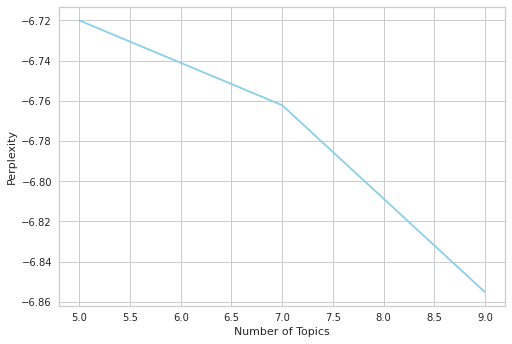

In [29]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

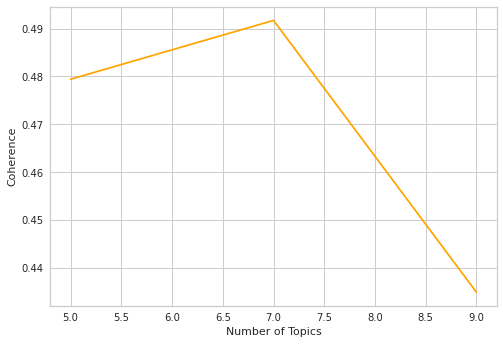

In [30]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Visualizing topics according to the best *n*

### Visualization with 5 topics

In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_5 = pyLDAvis.gensim.prepare(models[0], corpus, id2word, sort_topics=False)
vis_5

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      19.011087        1       1  0.165996 -0.108852
1      30.804964        1       2 -0.185023  0.216540
2      18.036465        1       3 -0.178441 -0.283267
3      14.482180        1       4 -0.071603  0.116404
4      17.665300        1       5  0.269072  0.059175, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
99    Default  43232.000000          room  43232.000000  30.0000  30.0000
96    Default  20777.000000       private  20777.000000  29.0000  29.0000
8     Default  19254.000000           bed  19254.000000  28.0000  28.0000
141   Default  19549.000000          walk  19549.000000  27.0000  27.0000
93    Default  18307.000000        minute  18307.000000  26.0000  26.0000
289   Default  12203.000000          stay  12203.000000  25.0000  25.0000
106   Default  19030.000000         train  19030.000000  24.0000  24.0000
218   Default  16595.000000    restaurant  16595.000000  23.0000  23.0000
63    Default  28415.000000       bedroom  28415.000000  22.0000  22.0000
182   Default  11178.000000         share  11178.000000  21.0000  21.0000
198   Default  13977.000000          away  13977.000000  20.0000  20.0000
87    Default  16284.000000         guest  16284.000000  19.0000  19.0000
62    Default  14340.000000      bathroom  14340.000000  18.0000  18.0000
131   Default   8023.000000         queen   8023.000000  17.0000  17.0000
20    Default  12491.000000          full  12491.000000  16.0000  16.0000
64    Default  11682.000000         block  11682.000000  15.0000  15.0000
309   Default  12212.000000          home  12212.000000  14.0000  14.0000
137   Default  11151.000000        subway  11151.000000  13.0000  13.0000
134   Default   7525.000000          size   7525.000000  12.0000  12.0000
127   Default  10602.000000        living  10602.000000  11.0000  11.0000
126   Default   9806.000000          live   9806.000000  10.0000  10.0000
202   Default  10223.000000         close  10223.000000   9.0000   9.0000
28    Default  11751.000000       kitchen  11751.000000   8.0000   8.0000
110   Default  43833.000000     apartment  43833.000000   7.0000   7.0000
228   Default   9428.000000           bar   9428.000000   6.0000   6.0000
185   Default  16356.000000         space  16356.000000   5.0000   5.0000
249   Default  12741.000000  neighborhood  12741.000000   4.0000   4.0000
19    Default  11539.000000         floor  11539.000000   3.0000   3.0000
136   Default   8075.000000       station   8075.000000   2.0000   2.0000
4     Default  12398.000000          area  12398.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
607    Topic5   1018.022705         dryer   1018.909912   1.7327  -5.7381
406    Topic5    989.496704        pillow    990.378357   1.7327  -5.7665
613    Topic5    983.531067        washer    984.419617   1.7327  -5.7725
217    Topic5    957.319519  refrigerator    958.202209   1.7326  -5.7995
911    Topic5    960.600342       heating    961.495422   1.7326  -5.7961
8      Topic5  19219.513672           bed  19254.425781   1.7318  -2.8000
21     Topic5   1858.180664       furnish   1861.145142   1.7320  -5.1363
394    Topic5   2160.963623         couch   2224.178467   1.7047  -4.9854
239    Topic5   5496.515137         fully   6288.145996   1.5990  -4.0518
158    Topic5   5693.508301       include   6646.698242   1.5788  -4.0166
71     Topic5   1440.687134        double   1489.790527   1.7001  -5.3908
623    Topic5   3217.808594         brand   3707.302002   1.5920  -4.5872
20     Topic5   8907.661133          full  12491.624023   1.3954  -3.5690
55     Topic5   3746.067139         towel   4656.516602   1.5160  -4.4352
236    Topic5   3875.355225         equip   4867.179688   1.5057  -4.4013
135    Topic5   3020.049561

In [32]:
pyLDAvis.save_html(vis_5, '../data/visualization_5_topics.html')

### Visualization with 7 topics

In [33]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_7 = pyLDAvis.gensim.prepare(models[1], corpus, id2word, sort_topics=False)
vis_7

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       9.389396        1       1  0.078794  0.294673
1      13.320785        1       2 -0.224344 -0.182761
2      19.682697        1       3  0.061505  0.118817
3       2.477171        1       4  0.318566 -0.088683
4       5.772554        1       5  0.128037 -0.249461
5      23.339466        1       6 -0.133478  0.138812
6      26.017935        1       7 -0.229080 -0.031397, topic_info=     Category          Freq            Term         Total  loglift  logprob
term                                                                       
99    Default  41507.000000            room  41507.000000  30.0000  30.0000
63    Default  30580.000000         bedroom  30580.000000  29.0000  29.0000
96    Default  20391.000000         private  20391.000000  28.0000  28.0000
289   Default  12405.000000            stay  12405.000000  27.0000  27.0000
8     Default  20926.000000             bed  20926.000000  26.0000  26.0000
141   Default  19653.000000            walk  19653.000000  25.0000  25.0000
182   Default  10732.000000           share  10732.000000  24.0000  24.0000
110   Default  46156.000000       apartment  46156.000000  23.0000  23.0000
93    Default  18404.000000          minute  18404.000000  22.0000  22.0000
106   Default  19127.000000           train  19127.000000  21.0000  21.0000
218   Default  16684.000000      restaurant  16684.000000  20.0000  20.0000
62    Default  14366.000000        bathroom  14366.000000  19.0000  19.0000
20    Default  13441.000000            full  13441.000000  18.0000  18.0000
198   Default  14052.000000            away  14052.000000  17.0000  17.0000
87    Default  16426.000000           guest  16426.000000  16.0000  16.0000
185   Default  16318.000000           space  16318.000000  15.0000  15.0000
127   Default  10601.000000          living  10601.000000  14.0000  14.0000
239   Default   5905.000000           fully   5905.000000  13.0000  13.0000
129   Default   8184.000000             new   8184.000000  12.0000  12.0000
64    Default  11744.000000           block  11744.000000  11.0000  11.0000
137   Default  11211.000000          subway  11211.000000  10.0000  10.0000
381   Default   5489.000000         provide   5489.000000   9.0000   9.0000
117   Default   7029.000000          coffee   7029.000000   8.0000   8.0000
309   Default  12036.000000            home  12036.000000   7.0000   7.0000
202   Default  10277.000000           close  10277.000000   6.0000   6.0000
113   Default   7146.000000        building   7146.000000   5.0000   5.0000
236   Default   4599.000000           equip   4599.000000   4.0000   4.0000
249   Default  12646.000000    neighborhood  12646.000000   3.0000   3.0000
228   Default   9478.000000             bar   9478.000000   2.0000   2.0000
28    Default  12224.000000         kitchen  12224.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
215    Topic7   4282.716797            park   4283.642578   1.3462  -4.6885
345    Topic7   4231.599121             min   4232.524902   1.3462  -4.7005
258    Topic7   3892.914307            stop   3893.839355   1.3461  -4.7840
346    Topic7   3153.575684          nearby   3154.502197   1.3461  -4.9946
570    Topic7   3018.766846        downtown   3019.692627   1.3461  -5.0383
840    Topic7   2959.481689         parking   2960.407959   1.3461  -5.0581
568    Topic7   2594.462402      convenient   2595.388916   1.3460  -5.1897
705    Topic7   2565.722168     supermarket   2566.646973   1.3460  -5.2009
747    Topic7   2470.855469          corner   2471.781006   1.3460  -5.2385
712    Topic7   2445.200684         grocery   2446.126221   1.3460  -5.2490
316    Topic7   2340.460938            ride   2341.386230   1.3460  -5.2928
634    Topic7   2337.540283        shopping   2338.465576   1.3460  -5.2940
223    Topic7   2075.525146  transportation   2076.

In [34]:
pyLDAvis.save_html(vis_7, '../data/visualization_7_topics.html')

### Visualization with 9 topics 

In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis_9 = pyLDAvis.gensim.prepare(models[2], corpus, id2word, sort_topics=False)
vis_9

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0       1.123304        1       1  0.265557  0.090885
1       8.404847        1       2  0.002922 -0.022948
2       6.583151        1       3  0.072124  0.233928
3      18.897709        1       4 -0.210402  0.148546
4       1.071411        1       5  0.286325 -0.009818
5      24.324032        1       6 -0.173355  0.153958
6       9.692666        1       7 -0.072509 -0.252841
7      24.379633        1       8 -0.228835 -0.074423
8       5.523247        1       9  0.058173 -0.267287, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
99    Default  40262.000000        room  40262.000000  30.0000  30.0000
87    Default  16046.000000       guest  16046.000000  29.0000  29.0000
63    Default  28932.000000     bedroom  28932.000000  28.0000  28.0000
96    Default  19793.000000     private  19793.000000  27.0000  27.0000
19    Default  12658.000000       floor  12658.000000  26.0000  26.0000
141   Default  19747.000000        walk  19747.000000  25.0000  25.0000
106   Default  19211.000000       train  19211.000000  24.0000  24.0000
289   Default  12685.000000        stay  12685.000000  23.0000  23.0000
93    Default  18492.000000      minute  18492.000000  22.0000  22.0000
8     Default  19856.000000         bed  19856.000000  21.0000  21.0000
218   Default  16763.000000  restaurant  16763.000000  20.0000  20.0000
182   Default  10307.000000       share  10307.000000  19.0000  19.0000
198   Default  14119.000000        away  14119.000000  18.0000  18.0000
110   Default  45138.000000   apartment  45138.000000  17.0000  17.0000
62    Default  13830.000000    bathroom  13830.000000  16.0000  16.0000
366   Default   8835.000000       clean   8835.000000  15.0000  15.0000
64    Default  11800.000000       block  11800.000000  14.0000  14.0000
137   Default  11264.000000      subway  11264.000000  13.0000  13.0000
20    Default  12716.000000        full  12716.000000  12.0000  12.0000
202   Default  10326.000000       close  10326.000000  11.0000  11.0000
28    Default  11800.000000     kitchen  11800.000000  10.0000  10.0000
6     Default  12222.000000   available  12222.000000   9.0000   9.0000
228   Default   9526.000000         bar   9526.000000   8.0000   8.0000
139   Default   8020.000000        time   8020.000000   7.0000   7.0000
37    Default   6210.000000      modern   6210.000000   6.0000   6.0000
309   Default  12228.000000        home  12228.000000   5.0000   5.0000
127   Default  10495.000000      living  10495.000000   4.0000   4.0000
175   Default  10171.000000       place  10171.000000   3.0000   3.0000
31    Default  14640.000000      locate  14640.000000   2.0000   2.0000
81    Default   4606.000000      family   4606.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
82     Topic9    785.016968      flight    785.964417   2.8950  -4.8353
478    Topic9    732.414673   townhouse    733.361938   2.8949  -4.9047
1279   Topic9    682.010437       spend    682.958069   2.8948  -4.9760
70     Topic9    674.267273     consist    675.215271   2.8948  -4.9874
480    Topic9    618.609314    upstairs    619.556824   2.8947  -5.0736
102    Topic9    613.514709       slope    614.462219   2.8947  -5.0818
355    Topic9    609.134705       story    610.082092   2.8947  -5.0890
528    Topic9    597.596069       third    598.543640   2.8946  -5.1081
791    Topic9    580.108276    original    581.055786   2.8946  -5.1378
567    Topic9    556.821716     classic    557.769226   2.8945  -5.1788
2679   Topic9    553.603149       class    554.551575   2.8945  -5.1846
814    Topic9    479.242279        deck    480.189728   2.8942  -5.3288
1081   Topic9    475.159180   brooklyns    476.110077   2.8942  -5.3374
95     Topic9    463.244873      occupy    464.1925

In [36]:
pyLDAvis.save_html(vis_9, '../data/visualization_9_topics.html')

## Creating DataFrame with scores and topics for 5 topics

In [37]:
# function that returns data frame with 
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     df_model_en_desc.reset_index(inplace=True)
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         print(row)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
    sent_topics_df = pd.concat([df_model_en_desc['id'],sent_topics_df], axis=1)
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [38]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[0], corpus=corpus, texts=lst_texts)

In [39]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5
0,2595.0,"(4, 0.48135576)","(3, 0.33526072)","(1, 0.11844611)","(0, 0.04409502)","(2, 0.020842375)"
1,3831.0,"(0, 0.29808682)","(3, 0.29150525)","(4, 0.16668631)","(1, 0.1568704)","(2, 0.08685127)"
2,5099.0,"(4, 0.31514826)","(1, 0.31156844)","(0, 0.21634653)","(3, 0.13034312)","(2, 0.026593655)"
3,5121.0,"(2, 0.569868)","(0, 0.19805808)","(3, 0.11040169)","(1, 0.07548536)","(4, 0.046186816)"
4,5178.0,"(4, 0.34084234)","(0, 0.22143047)","(2, 0.21037897)","(1, 0.2091523)","(3, 0.018195933)"


In [40]:
sent_topics_df.shape

(27855, 6)

In [41]:
sent_topics_df = sent_topics_df.dropna()

In [42]:
sent_topics_df.shape

(26357, 6)

### Separating the Topic from its score

In [43]:
for i in range(1,df_n_cols):
    top_col = 'topic' + str(i)
    score_col = 'score_dom_topic_' + str(i)
    sent_topics_df[top_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[0]
    sent_topics_df[score_col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [44]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,Dominant_Topic_4,Dominant_Topic_5,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,"(4, 0.48135576)","(3, 0.33526072)","(1, 0.11844611)","(0, 0.04409502)","(2, 0.020842375)",4,0.481356,3,0.335261,1,0.118446,0,0.044095,2,0.020842
1,3831.0,"(0, 0.29808682)","(3, 0.29150525)","(4, 0.16668631)","(1, 0.1568704)","(2, 0.08685127)",0,0.298087,3,0.291505,4,0.166686,1,0.156870,2,0.086851
2,5099.0,"(4, 0.31514826)","(1, 0.31156844)","(0, 0.21634653)","(3, 0.13034312)","(2, 0.026593655)",4,0.315148,1,0.311568,0,0.216347,3,0.130343,2,0.026594
3,5121.0,"(2, 0.569868)","(0, 0.19805808)","(3, 0.11040169)","(1, 0.07548536)","(4, 0.046186816)",2,0.569868,0,0.198058,3,0.110402,1,0.075485,4,0.046187
4,5178.0,"(4, 0.34084234)","(0, 0.22143047)","(2, 0.21037897)","(1, 0.2091523)","(3, 0.018195933)",4,0.340842,0,0.221430,2,0.210379,1,0.209152,3,0.018196


In [45]:
# Dropping columns with tuples
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3','Dominant_Topic_4','Dominant_Topic_5']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [46]:
sent_topics_df.head()

,id,topic1,score_dom_topic_1,topic2,score_dom_topic_2,topic3,score_dom_topic_3,topic4,score_dom_topic_4,topic5,score_dom_topic_5
0,2595.0,4,0.481356,3,0.335261,1,0.118446,0,0.044095,2,0.020842
1,3831.0,0,0.298087,3,0.291505,4,0.166686,1,0.156870,2,0.086851
2,5099.0,4,0.315148,1,0.311568,0,0.216347,3,0.130343,2,0.026594
3,5121.0,2,0.569868,0,0.198058,3,0.110402,1,0.075485,4,0.046187
4,5178.0,4,0.340842,0,0.221430,2,0.210379,1,0.209152,3,0.018196


In [47]:
# Formatting DataFrame
sent_topics_df.rename(columns={"topic1": "winner_topic",
                               "score_dom_topic_1":"winner_topic_score",
                               "topic2": "second_place_topic",
                               "score_dom_topic_2":"second_topic_score",
                               "topic3": "third_place_topic",
                               "score_dom_topic_3":"third_topic_score",
                               "topic4": "fourth_place_topic",
                               "score_dom_topic_4":"fourth_topic_score",
                              "topic5": "fifth_place_topic",
                               "score_dom_topic_5":"fifth_topic_score"},inplace=True)

In [48]:
sent_topics_df.head()

,id,winner_topic,winner_topic_score,second_place_topic,second_topic_score,third_place_topic,third_topic_score,fourth_place_topic,fourth_topic_score,fifth_place_topic,fifth_topic_score
0,2595.0,4,0.481356,3,0.335261,1,0.118446,0,0.044095,2,0.020842
1,3831.0,0,0.298087,3,0.291505,4,0.166686,1,0.156870,2,0.086851
2,5099.0,4,0.315148,1,0.311568,0,0.216347,3,0.130343,2,0.026594
3,5121.0,2,0.569868,0,0.198058,3,0.110402,1,0.075485,4,0.046187
4,5178.0,4,0.340842,0,0.221430,2,0.210379,1,0.209152,3,0.018196


## Modeling

In [49]:
# Merging the initial DataFrame with features with the topics DataFrame
df_model_en_desc_merged = pd.merge(left=df_model_en_desc, right=sent_topics_df, how='left', on='id')

In [50]:
df_model_en_desc_merged.iloc[:,0:6].head()

,id,host_since,host_is_superhost,host_identity_verified,is_location_exact,accommodates
0,2595,733294,0,1,0,2
1,3831,733383,0,1,1,3
2,5099,733440,0,0,0,2
3,5121,733441,0,0,0,2
4,5178,733469,0,0,1,2


In [51]:
df_model_en_desc_merged.shape

(27106, 57)

In [52]:
df_model_en_desc_merged = df_model_en_desc_merged.dropna()

In [53]:
df_model_en_desc_merged.shape

(26357, 57)

### Understanding the topic that appears as winner the most

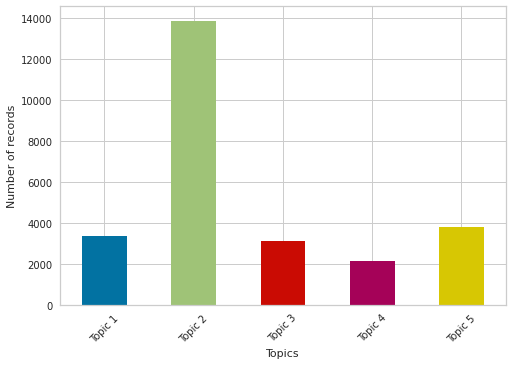

In [54]:
fig, ax = plt.subplots()
df = df_model_en_desc_merged.groupby('winner_topic').size().plot(kind='bar', x='topics', ax=ax)
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels[0] = 'Topic 1'
labels[1] = 'Topic 2'
labels[2] = 'Topic 3'
labels[3] = 'Topic 4'
labels[4] = 'Topic 5'

ax.set_xticklabels(labels,rotation='45')
ax.set(xlabel='Topics', ylabel='Number of records')

plt.show()

The above plot si a representation of the distribution of the topics as the first option for each docuement.

at this plot we can conclude tha the topic that appear to be more latent in the corpus is the green bar that corresponds to topic 2 and the less prevalent is topic4. Let's now take a more thorough look at the words that are in each topic to have a better understanding of wht might be happening.

### Word Clouds

In [55]:
num_topics = 5
topic_words = []
for i in range(num_topics):
    tt = models[0].get_topic_terms(i,20)
    topic_words.append([id2word[pair[0]] for pair in tt])

In [56]:
models[0].show_topic(0)

[('room', 0.12710245),
 ('private', 0.0609093),
 ('bedroom', 0.040391892),
 ('share', 0.032862872),
 ('bathroom', 0.03155373),
 ('living', 0.026064094),
 ('live', 0.025214626),
 ('space', 0.023669617),
 ('area', 0.022219883),
 ('kitchen', 0.018957961)]

In [57]:
df_top_30_n_5 = pd.DataFrame.from_records(topic_words)
df_top_30_n_5 = df_top_30_n_5.T

In [58]:
df_top_30_n_5.rename(columns={0: "Topic 1", 1: "Topic 2",
                              2: "Topic 3", 3: "Topic 4",
                              4: "Topic 5"}, inplace=True)

In [59]:
df_top_30_n_5

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,room,apartment,stay,apartment,bed
1,private,walk,guest,floor,bedroom
2,bedroom,train,home,modern,apartment
3,share,minute,need,light,full
4,bathroom,restaurant,place,home,queen
5,living,away,time,beautiful,size
6,live,block,clean,view,include
7,space,neighborhood,space,space,fully
8,area,subway,make,enjoy,kitchen
9,kitchen,locate,check,offer,new


In [60]:
top_0 = models[0].show_topic(0, 30)
top_1 = models[0].show_topic(1, 30)
top_2 = models[0].show_topic(2, 30)
top_3 = models[0].show_topic(3, 30)
top_4 = models[0].show_topic(4, 30)

In [61]:
def listtodict(A, di):
    di = dict(A)
    return di 

di_wc_0 = listtodict(top_0,{})
di_wc_1 = listtodict(top_1,{})
di_wc_2 = listtodict(top_2,{})
di_wc_3 = listtodict(top_3,{})
di_wc_4 = listtodict(top_4,{})

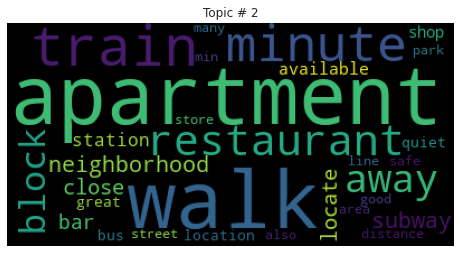

In [62]:
plt.figure()
plt.imshow(WordCloud().fit_words(di_wc_1))
plt.axis("off")
plt.title("Topic # 2")
plt.show()

It seems that Topic 2 has words related to location, for example: walk, train, neighborhood, block, close. This may lead to conclude that the majority of hosts recognize the importance of including such words into their description to attract guests. However, lets see if these words are actually influencing price. For this purpose we will try to understand the importance of each one of these topics' scores in our regression problem. We assume that the larger the impact of the score of each topic in the corpus, the most important to determine its price.

### Creating features X

In [63]:
X = df_model_en_desc_merged.iloc[:, 1:]
X = X.loc[:, X.columns != 'price']
X = X.loc[:, X.columns != 'content']
X = X.loc[:, X.columns != 'content_lang']

### Creating target y

In [64]:
y = df_model_en_desc_merged.price

### Cross validation with multiple regressors

In [65]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

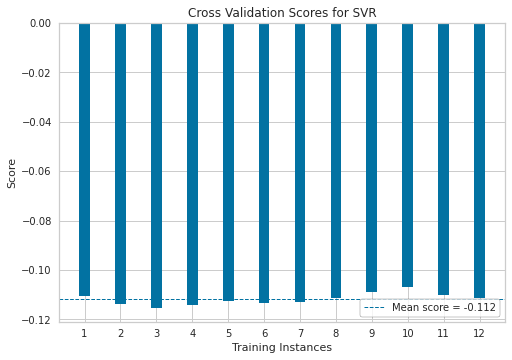

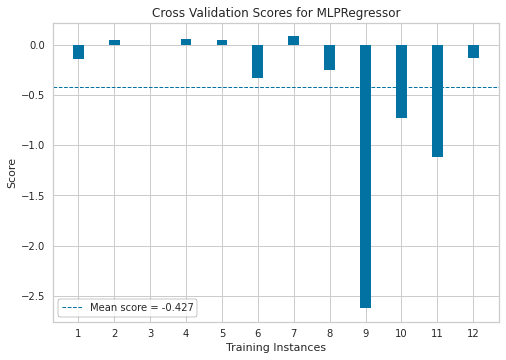

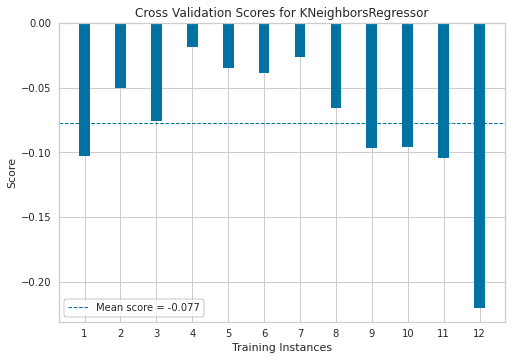

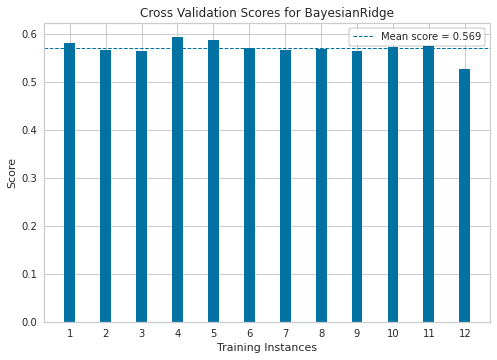

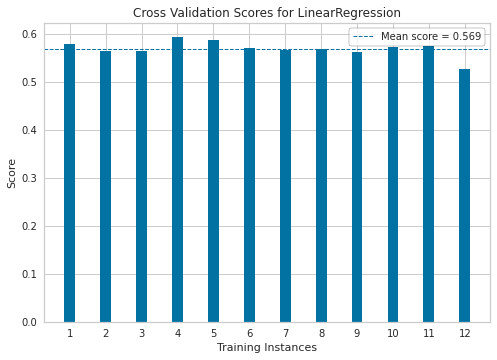

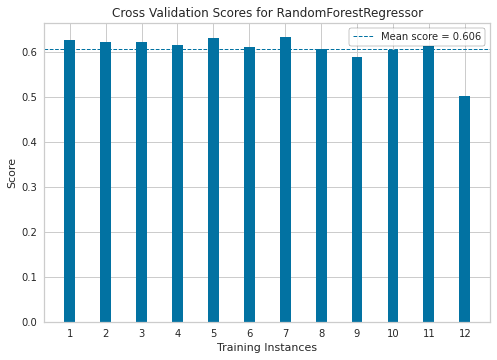

In [66]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = CVScores(regressor, cv=cv)
    visualizer.fit(X, y)
    visualizer.show()

## Residuals for multiple regression models

### Split train - test sets

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

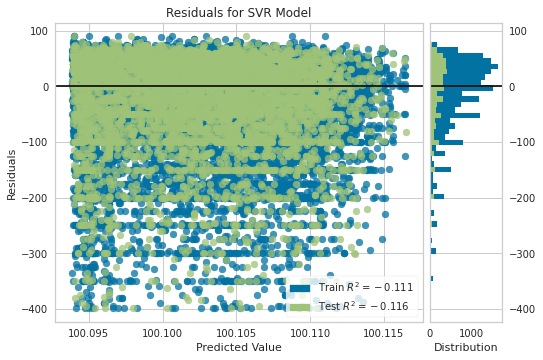

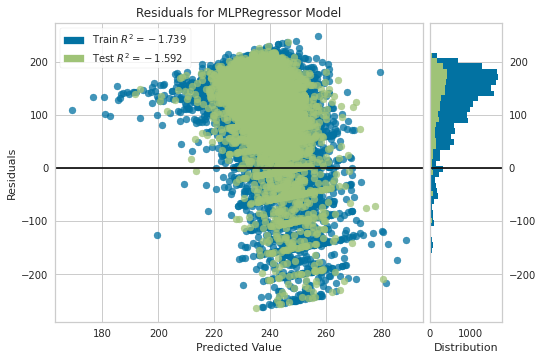

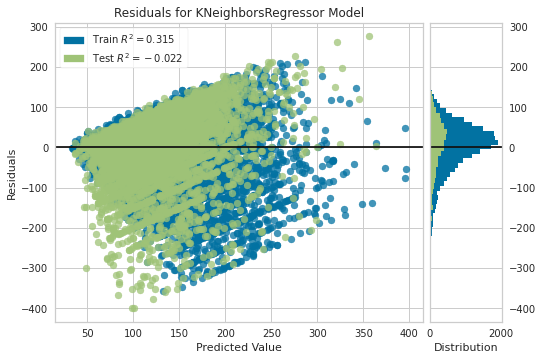

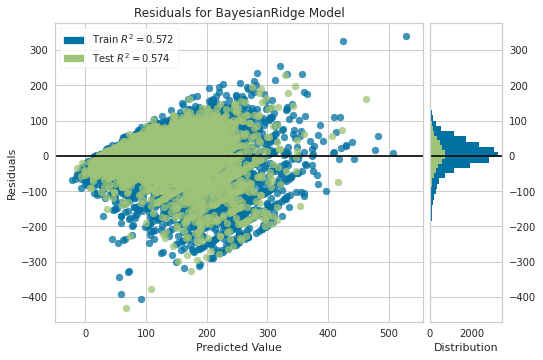

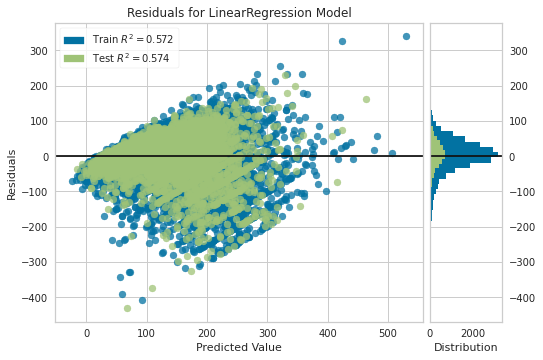

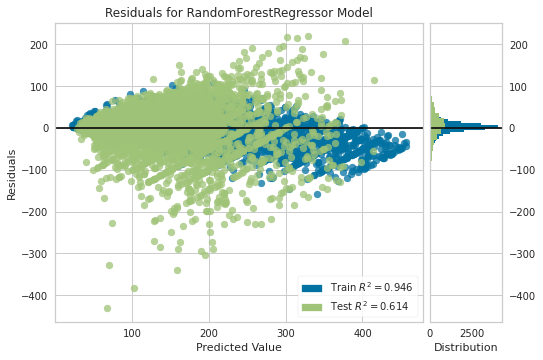

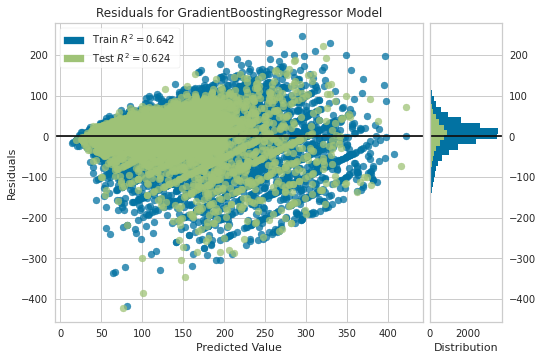

In [68]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
    "gradient boost regressor": GradientBoostingRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

After analyzing the average score in cross validations together with the residuals, we can continue to conclude that our baseline model is still the Random Forest Regressor. This excercise was fundamental to see that despite the addition of information about the description, this continues to be true. We will now continue doing some more experimentation.

## Experimenting with the baseline model using the Random Forest Regressor

Random Forest algorithms are ensemble methods of decision trees generated on a random split of a determined data set.The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In the case of regression, the average of all the tree outputs is considered as the final result. Source: https://www.datacamp.com/community/tutorials/random-forests-classifier-python

In [69]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [70]:
# making sure that the number of columns match with the features
X_train.shape, len(features), y_train.shape

((21085, 53), 53, (21085,))

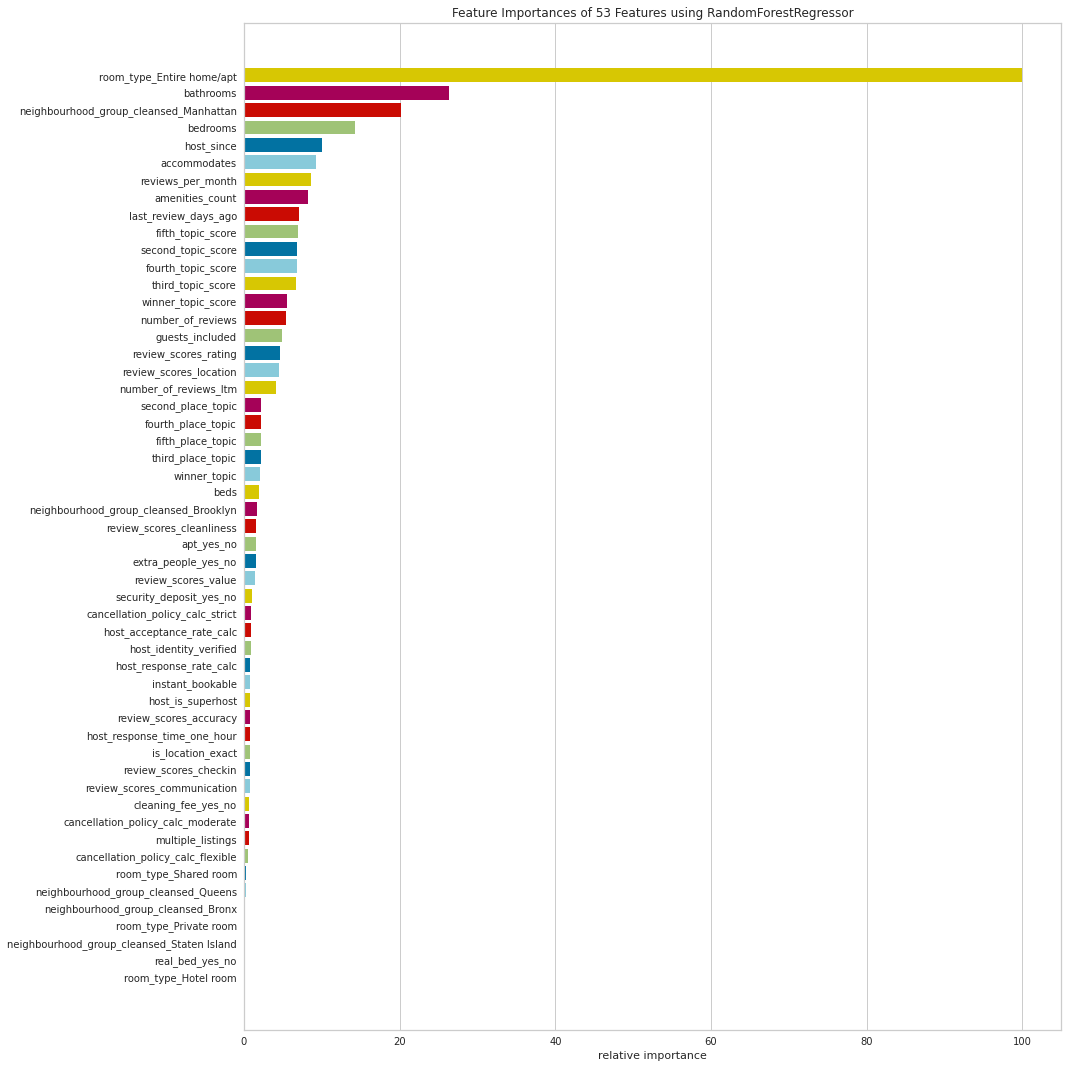

In [71]:
# Most important features
viz = FeatureImportances(regressors['random forest'], labels=features, size=(1080, 1080))
viz.fit(X_train, y_train)
viz.show()

### Creating a random variable 

As we can see in the feature importance graphic above we could conclude that the topics are part of the top features to determine price. To discard the fact that the impact of the scores is due to the fact that the values are numbers from a continuous distribution of numbers, we will create new column with random values from 0 to 1 and run the base regression again. In case this random doesn't appear as part of the next list of most relevant ones, we can be sure to discard this potential challenge

In [72]:
rand_var = list()
for i in range(X.shape[0]):
    rand_var.append(random.uniform(0, 1))

In [73]:
X['random cont variable'] = rand_var

In [74]:
X.shape

(26357, 54)

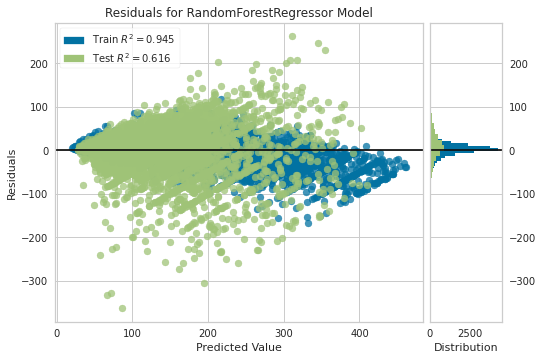

In [75]:
X_w_rand_train, X_w_rand_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_2 = ResidualsPlot(RandomForestRegressor())
visualizer_2.fit(X_w_rand_train, y_train)
visualizer_2.score(X_w_rand_test, y_test)
visualizer_2.show()

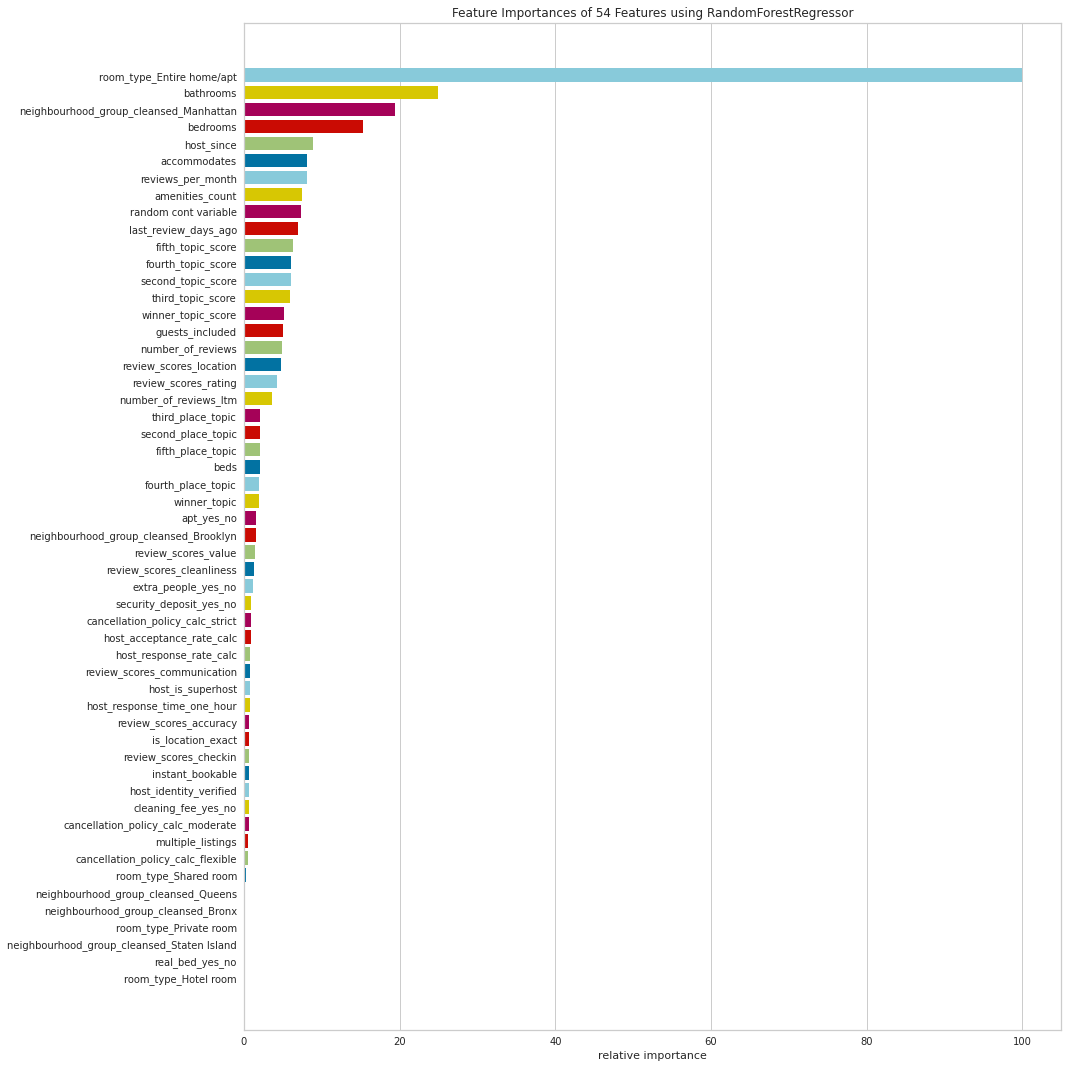

In [76]:
# Most important features
features_w_rand = features.append('random variable')
viz = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1080, 1080))
viz.fit(X_w_rand_train, y_train)
viz.show()

In [77]:
# X['neighbourhood_group_cleansed_Manhattan'].value_counts()
# X['neighbourhood_group_cleansed_Brooklyn'].value_counts()
# X['host_since'].value_counts()
# X['last_review_days_ago'].value_counts()

In [78]:
# X.columns

### Running the ensemble base model Random Forest removing room_type_Entire home/apt

In [79]:
X_not_prop_type = X.loc[:, X.columns != 'room_type_Entire home/apt']

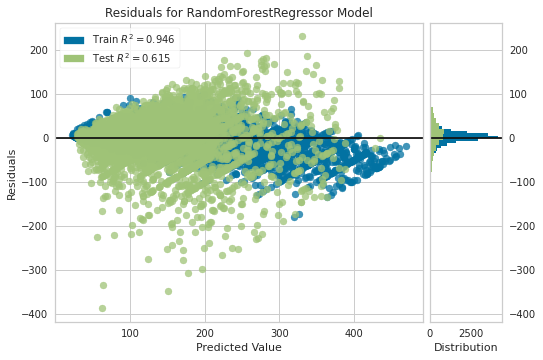

In [80]:
X_not_prop_type_train, X_not_prop_test, y_train, y_test = train_test_split(X_not_prop_type, y, test_size=0.2)

# Runing Random Forest with random variable
visualizer_3 = ResidualsPlot(RandomForestRegressor())
visualizer_3.fit(X_not_prop_type_train, y_train)
visualizer_3.score(X_not_prop_test, y_test)
visualizer_3.show()

In [81]:
# Most important features
features_not_property_typ = features.remove('room_type_Entire home/apt')

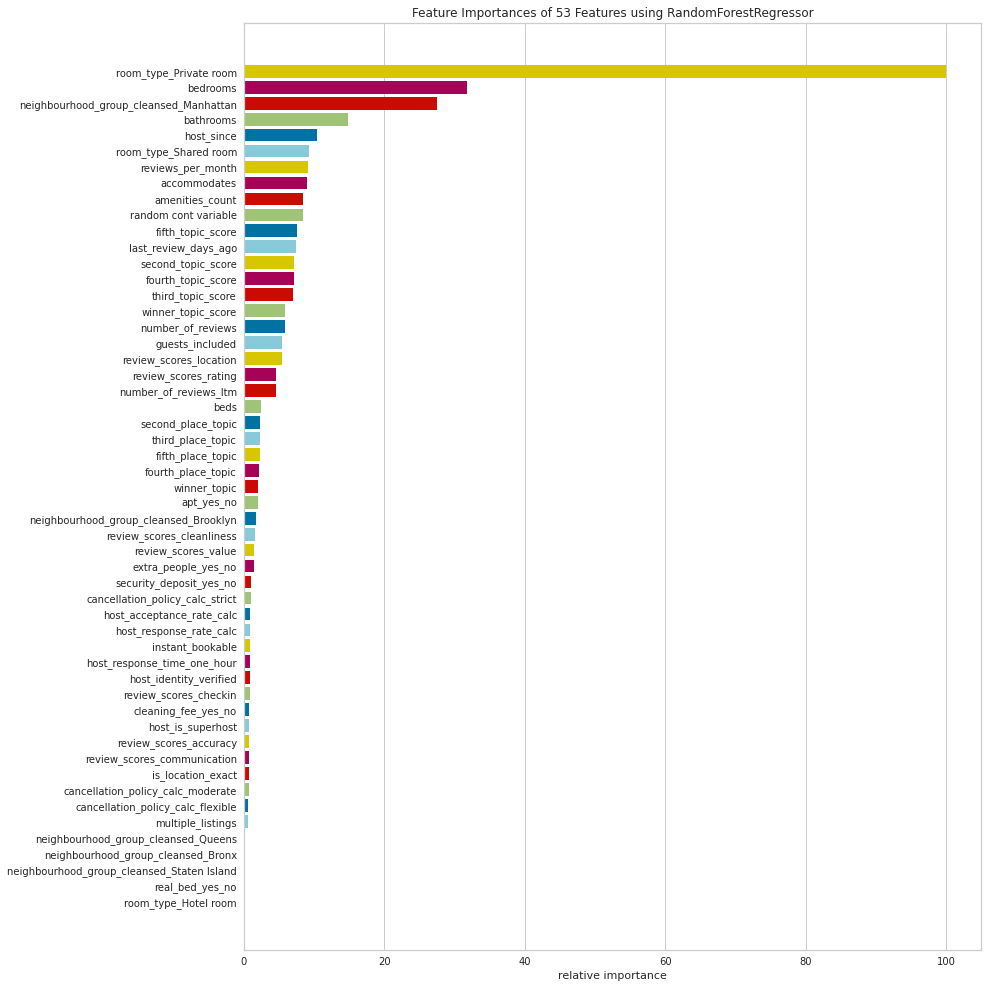

In [82]:
viz_3 = FeatureImportances(RandomForestRegressor(), labels=features_w_rand, size=(1000, 1000))
viz_3.fit(X_not_prop_type_train, y_train)
viz_3.show()

### Determining linearity between room type entire home/apt

In [83]:
df_col = pd.DataFrame()
df_col['room type'] = X['room_type_Entire home/apt']
df_col['price'] = y

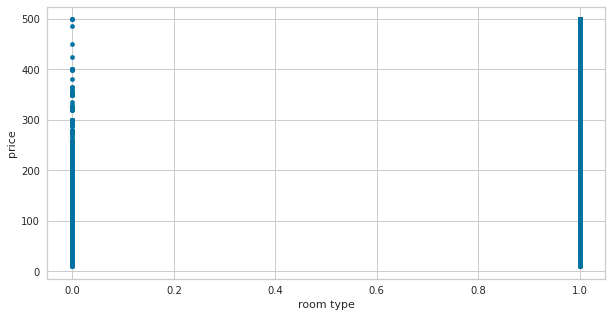

In [84]:
df_col.plot(kind='scatter', x='room type', y='price', figsize=(10,5), grid=True)
# X.plot(kind='scatter', x=X['room_type_Entire home/apt'], y=y, figsize=(10,5), grid=True)

In [ ]:
#hyper parameters
regressor = GradientBoostingRegressor()

n_estimators = [100,150,200]
max_depth = [2,3,4,5,6,7]
tuned_params = [{'max_depth': max_depth, 'n_estimators': n_estimators}]
n_folds = 10

grid = GridSearchCV(regressor, tuned_params, cv=10)

grid.fit(X_train, y_train)
print(grid.best_estimator_)

In [ ]:
#using CV, use best parameter from the grid
regressor = GradientBoostingRegressor(max_depth=6)
regressor = regressor.fit(X_train, y_train) 

#cross validation
scores = cross_val_score(estimator=regressor, X=X_train, y=y_train, cv=10, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores) 
print(rmse_scores)

In [ ]:
pred_train= regressor.predict(X_train)
print(rmse_scores.mean())
print(r2_score(y_train, pred_train))

In [ ]:
pred_test= regressor.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test))) 
print(r2_score(y_test, pred_test))

In [ ]:
#Instantiate the linear model and visualizer
visualizer = PredictionError(regressor, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

In [ ]:
#chart
oz = ResidualsPlot(regressor)

oz.fit(X_train, y_train)
oz.score(X_test, y_test)
_ = oz.show()

## Feature Importance

In [ ]:
# Creating a list of features to use as labels in FeatureImportances
features=list()

for col in df_model_en_desc_merged.columns:
    features.append(col)

# Removing price and id from labels
features.remove('price')
features.remove('content')
features.remove('content_lang')
features.remove('id')

In [ ]:
features

In [ ]:
# Most important features
viz_4 = FeatureImportances(RandomForestRegressor(), labels=features, size=(1000, 1000))
viz_4.fit(X_train, y_train)
viz_4.show()